![Movetru logo](../data/images/logo.webp)
# Gait event detection demo

This workbook contains a demo outlining a proof of concept for the gait event detection algorithm developed for the Movetru "Stage 2 Interview – Sports Biomechanics Data
Scientist Task". A complete brief is available in the parent directory as `brief.pdf`.

This notebook serves the purpose of explaining the algorithms and their implementation details, which are implemented in a more production-ready manner in the web app accompanying this work, which can be found [here](https://github.com/movetru/movetru-webapp).

In this notebook, the user selects the IMU data to use (choosing the participant and trial), explores the data, and runs the detection algorithm on it. 

The sample data used throughout this work comes from the dataset provided by [Grouvel et al., 2023](https://www-nature-com.eux.idm.oclc.org/articles/s41597-023-02077-3). 

The event detection algorithms are inspired by the works of [Hsu et al., 2014](https://ieeexplore-ieee-org.eux.idm.oclc.org/document/6824156) and [Brasiliano et al., 2023](https://www.mdpi.com/2072-666X/14/2/277).

## 1. Exploratory data analysis

Import the data for for a chosen participant, session and trial:

In [240]:
import polars as pl

# Participants available: P01-P10
participant = "P01"
# Sessions available: S01
session = "S01"
# Trials available: SlowGait, Gait, FastGait, Running
trial = "Gait"
# Trial IDs available: varies per trial. Here I use "01" as an example.
trial_id = "01"
# Sampling frequency (Hz)
fs = 100

# Load the data
sample_df = pl.read_csv(f"../data/synchronised/{participant}_{session}_{trial}_{trial_id}.csv")

We'll focus on the gyroscope data from the feet IMUs in the medial-lateral direction (which corresponds to the y-axis of the IMU), as this is the focus of the event detection algorithm. 

In [241]:
from scipy.signal import butter, filtfilt

left_foot = sample_df["P6_LF_gyro_y"]
right_foot = sample_df["P6_RF_gyro_y"]

Plot the signals to visualize the data:

Text(0, 0.5, 'Ang. velocity (deg/s)')

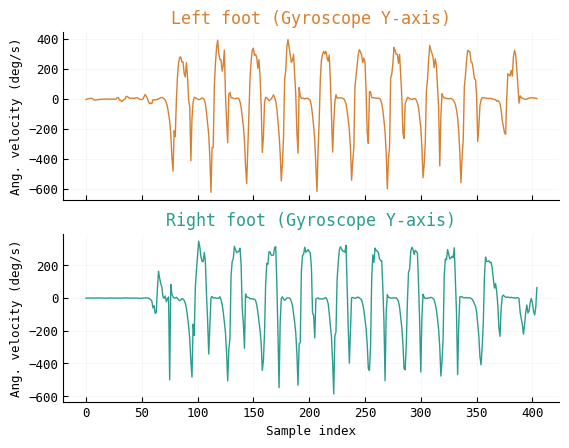

In [242]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("movetru.mplstyle")
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Calculate time values for the x-axis based on the sampling frequency
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(-left_foot, label="Left Foot Gyro Y", color=colours[0])
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
# ax[0].set_xlim([100, 200])
ax[1].plot(-right_foot, label="Right Foot Gyro Y", color=colours[1])
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")

## 2. Data cleaning

Although the data appears relatively clean and expectedly cyclic in nature, the event detection algorithm relies on the detection of local minima in the signal, which can be affected by high frequency noise.

Since we want the algorithm to also be near real-time, and robust across movement speeds (running, sprintig), any data cleaning strategy must:
1. Be causal (only use current and past data to filter the signal).
2. Computationally inexpensive.
3. Adaptable to different movement speeds, through the use of adaptive thresholds based on signal characteristics.

To satisfy point 1, we will use a simple moving average (SMA) filter, which is causal by nature.

To satisfy points 2 and 3, we will dynamically adjust the window size of the SMA filter based on an auto-correlation analysis of the signal. The window size will be set to five seconds worth of samples.

In [243]:
from collections import deque

def moving_average(x, window=5):
    ''' Compute the moving average live'''
    if len(x) < window:
        # Not enough data yet, return mean of what we have
        return np.mean(x) if len(x) > 0 else 0
    
    # Compute moving average of last 'window' samples
    return np.mean(x[-window:])


In [244]:
# Initialize state for both feet
feet_data = {
    'left': {'raw_signal': left_foot},
    'right': {'raw_signal': right_foot}
}

max_window_size = fs * 5  # Keep last 5 seconds of data in rolling window

for foot_name, foot_state in feet_data.items():
    foot_state['window'] = deque(maxlen=max_window_size)
    foot_state['all_smoothed'] = []

# Simulate receiving the data sample-by-sample
for i in range(len(left_foot)):
    for foot_name, foot_state in feet_data.items():
        # Add new sample to rolling window
        foot_state['window'].append(foot_state['raw_signal'][i])
        
        # Compute moving average on the rolling window
        smooth_value = moving_average(np.array(foot_state['window']), window=5)
        
        # Store smoothed value for plotting
        foot_state['all_smoothed'].append(smooth_value)

# Convert to numpy arrays for plotting
left_smoothed = np.array(feet_data['left']['all_smoothed'])
right_smoothed = np.array(feet_data['right']['all_smoothed'])


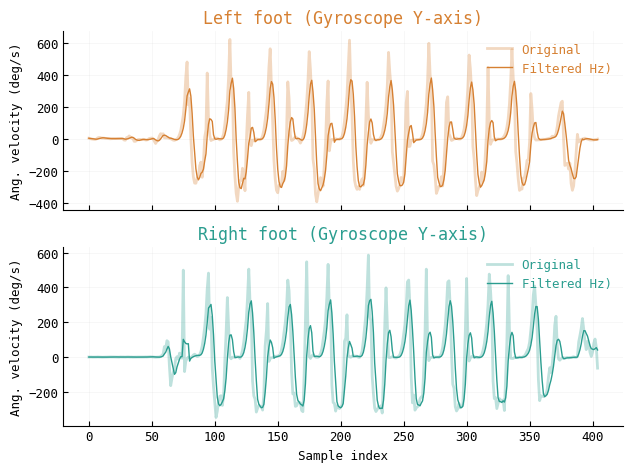

In [245]:
# Plot original and filtered signals
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_foot, label="Original", color=colours[0], alpha=0.3, linewidth=2)
ax[0].plot(left_smoothed, label=f"Filtered Hz)", color=colours[0], linewidth=1)
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper right')

# Right foot
ax[1].plot(right_foot, label="Original", color=colours[1], alpha=0.3, linewidth=2)
ax[1].plot(right_smoothed, label=f"Filtered Hz)", color=colours[1], linewidth=1)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper right')
plt.tight_layout()
plt.show()

## 3. Event detection

The filtered data now follows a clear trend: each local minima is followed by two local maxima.

From the typical healthy gait cycle, these minima correspond to the time between the foot off and foot contact events, also referred to as the mid-swing (MSW).

![Gait cycle](../data/images/typical_gait.png)

The local minima can therefore be used as an anchor from which to search to the left (for peaks corresponding to foot offs) and right (for zero-crossings corresponding to foot contacts).

### Real-time Mid-Swing Detection Algorithm

The algorithm works as follows:
1. **Track zero-crossings**: Monitor when the signal crosses zero (from positive to negative = descending ZC)
2. **After descending ZC**: Search for the first local minimum below a threshold
3. **Local minimum conditions**: 
   - Current value < previous value AND current value < next value
   - Current value < threshold (typically negative, e.g., < -100 deg/s)
   - Must occur after a descending zero-crossing

This approach is causal and suitable for real-time processing.

In [246]:
def detect_zero_crossing_descending(current_value, previous_state, threshold=0):
    """ Detect descending zero-crossing (transition from positive to negative). """
    current_state = current_value >= threshold
    is_descending_zc = False
    
    if previous_state is not None:
        # Descending ZC: was positive (True), now negative (False)
        if previous_state and not current_state:
            is_descending_zc = True
    
    return current_state, is_descending_zc


def detect_local_minimum(history, threshold):
    """ Detect local minimum using 3-sample window. """
    if len(history) < 3:
        return False
    
    prev_sample = history[0]   # i-2
    curr_sample = history[1]   # i-1 (candidate for local minimum)
    next_sample = history[2]   # i (current)
    
    # Check if middle sample is a local minimum
    is_local_min = (prev_sample >= curr_sample) and (curr_sample <= next_sample)
    below_threshold = curr_sample < threshold
    
    return is_local_min and below_threshold

In [247]:
# Real-time streaming simulation: smoothing + mid-swing detection
# Based on Brasiliano et al., 2023 algorithm

# Parameters
msw_threshold = -115  # deg/s (= -2 rad/s)
zc_threshold = 0      # deg/s
ma_window = 5         # Moving average window size
max_buffer_size = fs * 5  # Keep last 5 seconds for smoothing

# Initialize state for both feet
feet_data = {
    'left': {'raw_signal': left_foot},
    'right': {'raw_signal': right_foot}
}

for foot_name, foot_state in feet_data.items():
    # Smoothing buffers
    foot_state['raw_buffer'] = deque(maxlen=max_buffer_size)
    foot_state['smoothed_history'] = []  # Store last 3 smoothed samples for min detection
    foot_state['all_smoothed'] = []  # Store ALL smoothed values for plotting
    
    # Event detection state
    foot_state['zc_prev'] = None
    foot_state['after_desc_zc'] = False
    foot_state['msw_indices'] = []
    foot_state['zc_desc_indices'] = []

# Simulate receiving RAW data sample-by-sample
for i in range(len(left_foot)):
    
    for foot_name, foot_state in feet_data.items():
        # STEP 1: Get new raw sample 
        raw_sample = foot_state['raw_signal'][i]
        
        # STEP 2: Update smoothing buffer 
        foot_state['raw_buffer'].append(raw_sample)
        
        # STEP 3: Compute smoothed value (moving average) 
        smoothed_sample = moving_average(np.array(foot_state['raw_buffer']), window=ma_window)
        foot_state['all_smoothed'].append(smoothed_sample)
        
        # STEP 4: Event Detection 
        # 1. Update history buffer for local minima detection (keep last 3 smoothed samples)
        foot_state['smoothed_history'].append(smoothed_sample)
        if len(foot_state['smoothed_history']) > 3:
            foot_state['smoothed_history'].pop(0)
        
        # 2. Detect zero-crossing
        foot_state['zc_prev'], is_desc_zc = detect_zero_crossing_descending(
            smoothed_sample, foot_state['zc_prev'], zc_threshold
        )
        
        if is_desc_zc:
            foot_state['after_desc_zc'] = True
            foot_state['zc_desc_indices'].append(i)
        
        # 3. Detect local minimum after descending zero-crossing
        if foot_state['after_desc_zc']:
            if detect_local_minimum(foot_state['smoothed_history'], msw_threshold):
                foot_state['msw_indices'].append(i - 1)  # The local min is at i-1
                foot_state['after_desc_zc'] = False  # Reset flag after detecting MSW

# Convert to numpy arrays for easier downstream processing
left_smoothed = np.array(feet_data['left']['all_smoothed'])
right_smoothed = np.array(feet_data['right']['all_smoothed'])
msw_left = np.array(feet_data['left']['msw_indices'])
msw_right = np.array(feet_data['right']['msw_indices'])
zc_left = np.array(feet_data['left']['zc_desc_indices'])
zc_right = np.array(feet_data['right']['zc_desc_indices'])

### Visualize detected mid-swing events

Let's visualize the detected events along with the zero-crossings to verify the algorithm is working correctly:

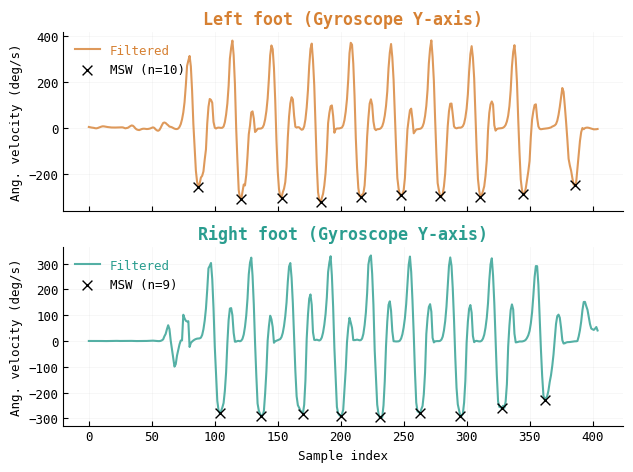

In [248]:
# Plot original signal with detected mid-swing events and zero-crossings
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_smoothed, label=f"Filtered", color=colours[0], linewidth=1.5, alpha=0.8)
ax[0].scatter(msw_left, left_smoothed[msw_left], color='black', s=50, zorder=5, 
             label=f'MSW (n={len(msw_left)})', marker='x', linewidths=1)
ax[0].set_title("Left foot (Gyroscope Y-axis)", fontweight='bold')
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left')

# Right foot
ax[1].plot(right_smoothed, label=f"Filtered", color=colours[1], linewidth=1.5, alpha=0.8)
ax[1].scatter(msw_right, right_smoothed[msw_right], color='black', s=50, zorder=5, 
             label=f'MSW (n={len(msw_right)})', marker='x', linewidths=1)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1], fontweight='bold')
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

### Foot strike (FS) and foot off (FO) detection

We can search between consecutively detected MSWs for the peaks corresponding to the FS and FOs.


In [249]:
def compute_angular_velocity_norm(gyro_x, gyro_y, gyro_z):
    """Compute the norm of the angular velocity vector."""
    return np.sqrt(gyro_x**2 + gyro_y**2 + gyro_z**2)


def detect_mid_stance(signal, msw_start_idx, msw_end_idx):
    """
    Detect mid-stance as the minimum angular velocity norm in the 30-45% 
    time-range between consecutive mid-swings.
    """
    cycle_length = msw_end_idx - msw_start_idx
    
    # Define 30-45% time range
    start_search = msw_start_idx + int(0.3 * cycle_length)
    end_search = msw_start_idx + int(0.6 * cycle_length)
    
    # Ensure valid range
    if start_search >= end_search or end_search > msw_end_idx:

        return None
    
    # Find minimum in this range
    search_segment = signal[start_search:end_search]
    min_idx_relative = np.argmin(search_segment)
    
    return start_search + min_idx_relative


def detect_foot_strike(signal, msw_idx, mid_stance_idx):
    """ Detect foot strike as the maximum angular velocity between 
    mid-swing and mid-stance. """
    if msw_idx >= mid_stance_idx:
        return None
    
    # Search between MSW and mid-stance
    search_segment = signal[msw_idx:mid_stance_idx]
    max_idx_relative = np.argmax(search_segment)
    
    return msw_idx + max_idx_relative


def detect_foot_off(signal, mid_stance_idx, next_msw_idx):
    """ Detect foot off as the maximum angular velocity between 
    mid-stance and next mid-swing. """
    if mid_stance_idx >= next_msw_idx:
        return None
    
    # Search between mid-stance and next MSW
    search_segment = signal[mid_stance_idx:next_msw_idx]
    max_idx_relative = np.argmax(search_segment)
    
    return mid_stance_idx + max_idx_relative


def is_valid_stride(msw1_idx, msw2_idx, fs, max_stride_time=2.5):
    """ Check if two consecutive mid-swings are within a reasonable time range
    to be considered part of the same stride pattern. """
    stride_time = (msw2_idx - msw1_idx) / fs
    return 0.05 < stride_time < max_stride_time  # Minimum 0.1s for very fast running


In [250]:
# Real-time streaming simulation: complete gait event detection pipeline
# Detects MSW → triggers retrospective search for FS/MS/FO between previous and current MSW

# Parameters
msw_threshold = -115  # deg/s (= -2 rad/s)
zc_threshold = 0      # deg/s
ma_window = 5         # Moving average window size
max_buffer_size = fs * 5  # Keep last 5 seconds for smoothing
max_stride_time = 2.5  # seconds

print("Simulating complete real-time pipeline: raw data → smoothing → MSW detection → FS/MS/FO detection")
print(f"Moving average window: {ma_window} samples")
print(f"MSW threshold: {msw_threshold} deg/s")
print(f"Max stride time: {max_stride_time}s")
print()

# Initialize state for both feet
feet_data = {
    'left': {'raw_signal': left_foot},
    'right': {'raw_signal': right_foot}
}

for foot_name, foot_state in feet_data.items():
    # Smoothing buffers
    foot_state['raw_buffer'] = deque(maxlen=max_buffer_size)
    foot_state['smoothed_history'] = []  # Last 3 samples for MSW detection
    foot_state['all_smoothed'] = []  # All smoothed values
    
    # MSW detection state
    foot_state['zc_prev'] = None
    foot_state['after_desc_zc'] = False
    foot_state['msw_indices'] = []
    foot_state['zc_desc_indices'] = []
    
    # Gait event detection state
    foot_state['previous_msw'] = None  # Track the previous MSW for pair detection
    foot_state['mid_stance_indices'] = []
    foot_state['foot_strike_indices'] = []
    foot_state['foot_off_indices'] = []

# Main streaming loop: process samples one by one
for i in range(len(left_foot)):
    
    for foot_name, foot_state in feet_data.items():
        # ========== STEP 1: Get new raw sample ==========
        raw_sample = foot_state['raw_signal'][i]
        
        # ========== STEP 2: Update smoothing buffer ==========
        foot_state['raw_buffer'].append(raw_sample)
        
        # ========== STEP 3: Compute smoothed value ==========
        smoothed_sample = moving_average(np.array(foot_state['raw_buffer']), window=ma_window)
        foot_state['all_smoothed'].append(smoothed_sample)
        
        # ========== STEP 4: MSW Detection ==========
        # Update history for local minima detection
        foot_state['smoothed_history'].append(smoothed_sample)
        if len(foot_state['smoothed_history']) > 3:
            foot_state['smoothed_history'].pop(0)
        
        # Detect zero-crossing
        foot_state['zc_prev'], is_desc_zc = detect_zero_crossing_descending(
            smoothed_sample, foot_state['zc_prev'], zc_threshold
        )
        
        if is_desc_zc:
            foot_state['after_desc_zc'] = True
            foot_state['zc_desc_indices'].append(i)
        
        # Detect local minimum after descending zero-crossing
        if foot_state['after_desc_zc']:
            if detect_local_minimum(foot_state['smoothed_history'], msw_threshold):
                current_msw = i - 1  # The local min is at i-1
                foot_state['msw_indices'].append(current_msw)
                foot_state['after_desc_zc'] = False
                
                # ========== STEP 5: Retrospective FS/MS/FO Detection ==========
                # When a new MSW is detected, check if we have a previous MSW to form a pair
                if foot_state['previous_msw'] is not None:
                    prev_msw = foot_state['previous_msw']
                    
                    # Check if this forms a valid stride
                    if is_valid_stride(prev_msw, current_msw, fs, max_stride_time):
                        # Convert smoothed data to numpy for processing
                        smoothed_signal = np.array(foot_state['all_smoothed'])
                        signal_norm = np.abs(smoothed_signal)  # Proxy for angular velocity norm (for mid-stance)
                        
                        # Detect mid-stance (30-45% of cycle, minimum of norm)
                        mid_stance_idx = detect_mid_stance(signal_norm, prev_msw, current_msw)
                        
                        if mid_stance_idx is not None:
                            foot_state['mid_stance_indices'].append(mid_stance_idx)
                            
                            # Detect foot strike (max POSITIVE angular velocity between previous MSW and mid-stance)
                            fs_idx = detect_foot_strike(smoothed_signal, prev_msw, mid_stance_idx)
                            if fs_idx is not None:
                                foot_state['foot_strike_indices'].append(fs_idx)
                            
                            # Detect foot off (max POSITIVE angular velocity between mid-stance and current MSW)
                            fo_idx = detect_foot_off(smoothed_signal, mid_stance_idx, current_msw)
                            if fo_idx is not None:
                                foot_state['foot_off_indices'].append(fo_idx)
                
                # Update previous MSW for next iteration
                foot_state['previous_msw'] = current_msw

# Convert to numpy arrays for easier downstream processing
left_smoothed = np.array(feet_data['left']['all_smoothed'])
right_smoothed = np.array(feet_data['right']['all_smoothed'])
msw_left = np.array(feet_data['left']['msw_indices'])
msw_right = np.array(feet_data['right']['msw_indices'])
zc_left = np.array(feet_data['left']['zc_desc_indices'])
zc_right = np.array(feet_data['right']['zc_desc_indices'])

# Gait events
ms_left = np.array(feet_data['left']['mid_stance_indices'])
ms_right = np.array(feet_data['right']['mid_stance_indices'])
fs_left = np.array(feet_data['left']['foot_strike_indices'])
fs_right = np.array(feet_data['right']['foot_strike_indices'])
fo_left = np.array(feet_data['left']['foot_off_indices'])
fo_right = np.array(feet_data['right']['foot_off_indices'])

print(f"Processed {len(left_foot)} raw samples")
print(f"\nMid-swing detection results:")
print(f"  Left foot:  {len(msw_left)} mid-swings")
print(f"  Right foot: {len(msw_right)} mid-swings")
print(f"\nGait event detection results:")
print(f"  Left foot:  {len(fs_left)} foot strikes, {len(ms_left)} mid-stances, {len(fo_left)} foot offs")
print(f"  Right foot: {len(fs_right)} foot strikes, {len(ms_right)} mid-stances, {len(fo_right)} foot offs")

# Calculate temporal metrics
if len(fs_left) > 0 and len(fo_left) > 0:
    # Stance time (FS to FO)
    min_len = min(len(fs_left), len(fo_left))
    stance_times_left = (fo_left[:min_len] - fs_left[:min_len]) / fs
    
    # Swing time (FO to next FS)
    if len(fs_left) > 1:
        swing_times_left = (fs_left[1:min_len] - fo_left[:min_len-1]) / fs
        print(f"\nLeft foot temporal metrics:")
        print(f"  Stance time: {np.mean(stance_times_left):.3f}s ± {np.std(stance_times_left):.3f}s")
        if len(swing_times_left) > 0:
            print(f"  Swing time:  {np.mean(swing_times_left):.3f}s ± {np.std(swing_times_left):.3f}s")

if len(fs_right) > 0 and len(fo_right) > 0:
    # Stance time (FS to FO)
    min_len = min(len(fs_right), len(fo_right))
    stance_times_right = (fo_right[:min_len] - fs_right[:min_len]) / fs
    
    # Swing time (FO to next FS)
    if len(fs_right) > 1:
        swing_times_right = (fs_right[1:min_len] - fo_right[:min_len-1]) / fs
        print(f"\nRight foot temporal metrics:")
        print(f"  Stance time: {np.mean(stance_times_right):.3f}s ± {np.std(stance_times_right):.3f}s")
        if len(swing_times_right) > 0:
            print(f"  Swing time:  {np.mean(swing_times_right):.3f}s ± {np.std(swing_times_right):.3f}s")


Simulating complete real-time pipeline: raw data → smoothing → MSW detection → FS/MS/FO detection
Moving average window: 5 samples
MSW threshold: -115 deg/s
Max stride time: 2.5s

Processed 405 raw samples

Mid-swing detection results:
  Left foot:  10 mid-swings
  Right foot: 9 mid-swings

Gait event detection results:
  Left foot:  9 foot strikes, 9 mid-stances, 9 foot offs
  Right foot: 8 foot strikes, 8 mid-stances, 8 foot offs

Left foot temporal metrics:
  Stance time: 0.168s ± 0.018s
  Swing time:  0.161s ± 0.003s

Right foot temporal metrics:
  Stance time: 0.166s ± 0.010s
  Swing time:  0.156s ± 0.005s


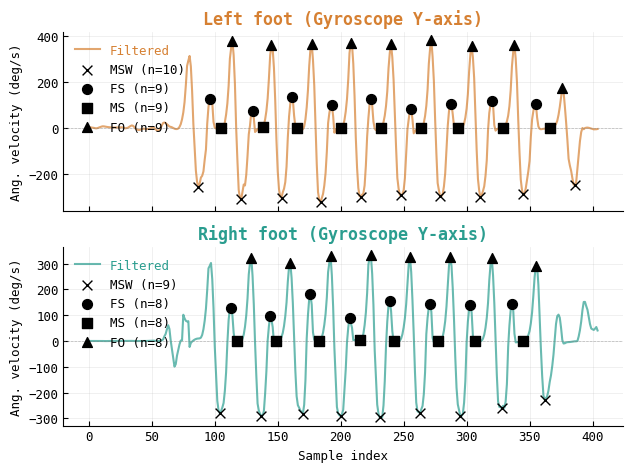

In [251]:
# Plot filtered signal with all detected gait events
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_smoothed, label="Filtered", color=colours[0], linewidth=1.5, alpha=0.7)
ax[0].scatter(msw_left, left_smoothed[msw_left], color='black', s=50, zorder=5, 
             label=f'MSW (n={len(msw_left)})', marker='x', linewidths=1)
ax[0].scatter(fs_left, left_smoothed[fs_left], color='black', s=50, zorder=5, 
             label=f'FS (n={len(fs_left)})', marker='o')
ax[0].scatter(ms_left, left_smoothed[ms_left], color='black', s=50, zorder=5, 
             label=f'MS (n={len(ms_left)})', marker='s')
ax[0].scatter(fo_left, left_smoothed[fo_left], color='black', s=50, zorder=5, 
             label=f'FO (n={len(fo_left)})', marker='^')
ax[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax[0].set_title("Left foot (Gyroscope Y-axis)", fontweight='bold')
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left')
ax[0].grid(True, alpha=0.3)

# Right foot
ax[1].plot(right_smoothed, label="Filtered", color=colours[1], linewidth=1.5, alpha=0.7)
ax[1].scatter(msw_right, right_smoothed[msw_right], color='black', s=50, zorder=5, 
             label=f'MSW (n={len(msw_right)})', marker='x', linewidths=1)
ax[1].scatter(fs_right, right_smoothed[fs_right], color='black', s=50, zorder=5, 
             label=f'FS (n={len(fs_right)})', marker='o')
ax[1].scatter(ms_right, right_smoothed[ms_right], color='black', s=50, zorder=5, 
             label=f'MS (n={len(ms_right)})', marker='s')
ax[1].scatter(fo_right, right_smoothed[fo_right], color='black', s=50, zorder=5, 
             label=f'FO (n={len(fo_right)})', marker='^')
ax[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1], fontweight='bold')
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Parameters for Streamlit App

The gait detection algorithm has been implemented in the Streamlit app (`app.py`) with the following parameters optimized for the 256 Hz sampling rate of the parquet files:

**Detection Parameters:**
- **Mid-swing threshold**: -115 deg/s (same as notebook)
- **Zero-crossing threshold**: 0 deg/s (same as notebook)
- **Moving average window**: 15 samples (adjusted for 256 Hz vs 100 Hz in this notebook)
- **Maximum buffer size**: 1280 samples (5 seconds at 256 Hz)
- **Maximum stride time**: 2.5 seconds
- **Minimum stride time**: 0.1 seconds

**Visualization:**
- **MSW events**: Plotted in real-time with black X markers
- **FS events**: Plotted retrospectively with black circle markers
- **FO events**: Plotted retrospectively with black triangle-up markers
- **MS events**: Detected but not plotted (used for FS/FO detection)

**Metrics Display:**
- **Recent metrics**: Last 5 seconds of data
- **Overall metrics**: Entire session
- Includes: stride count, stance time (mean ± std), swing time (mean ± std), stride time (mean ± std)